In [44]:
# KT Noted: Using CUBEMS environment
# KT Noted: ChatGPT o3-mini-high (7 Feb 2025)

In [45]:
import time
import pandas as pd
import numpy as np
from scipy import stats

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [47]:
import optuna
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [48]:
# Set a global random seed
SEED = 42
np.random.seed(SEED)

In [49]:
# -------------------------------
# 1. Data Preparation & Splitting
# -------------------------------

In [50]:
# Load the CSV file
file_path = r"C:\Users\kornn\Dropbox\00_EnergyModel_Weather\Dataset\Training_Combinded\train_df.csv"  
train_df = pd.read_csv(file_path)
train_df.head()

,Date,Total_kWh,Hour_of_Day,Day_of_week,Holiday,Weekend,Weekday,Working_Hour,Noon,Temperature,Dew Point,Humidity,Pressure,Solar
0,2018-07-01 00:00:00,176.261667,0,6,0,1,0,0,0,25.0,24.2,95,1006.43,0
1,2018-07-01 01:00:00,177.300000,1,6,0,1,0,0,0,25.5,24.8,96,1006.43,0
2,2018-07-01 02:00:00,177.048833,2,6,0,1,0,0,0,25.8,24.9,95,1005.76,0
3,2018-07-01 03:00:00,175.129167,3,6,0,1,0,0,0,25.7,24.7,94,1005.08,0
4,2018-07-01 04:00:00,183.175000,4,6,0,1,0,0,0,26.3,24.6,90,1005.42,0


In [51]:
train_df['Date'] = pd.to_datetime(train_df['Date']) # Make Date column is in datetime format

In [52]:
# Train and Test Split 
train_set = (train_df['Date'] >= '2018-07-01 00:00:00') & (train_df['Date'] <= '2019-06-30 23:00:00')
test_set = (train_df['Date'] >= '2019-07-01 00:00:00') & (train_df['Date'] <= '2019-08-31 23:00:00')

In [53]:
# Create the training and test DataFrames
train_data = train_df.loc[train_set].copy()
test_data = train_df.loc[test_set].copy()

In [54]:
# -------------------------------
# 2. Set Features and Target
# -------------------------------

In [55]:
target_col = 'Total_kWh' # Set the target variable
feature_cols = [col for col in train_df.columns if col not in ['Date', target_col]] # Set the features

In [56]:
X_train = train_data[feature_cols]
y_train = train_data[target_col]
X_test = test_data[feature_cols]
y_test = test_data[target_col]

In [57]:
# -------------------------------
# 3. Model Training with LightGBM
# -------------------------------

In [58]:
# My parameters for the LightGBM model (Optuna)
my_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'random_state': SEED,
    'feature_fraction': 0.869,
    'bagging_fraction': 0.945,
    'bagging_freq': 3,
    'learning_rate': 0.013,
    'num_leaves': 39,
    'max_depth': 16,
    'n_estimators': 776,
    'min_data_in_leaf': 44,
    'min_gain_to_split': 0.0,
    'lambda_l1': 0.0,
    'lambda_l2': 0.0
}

In [59]:
model = lgb.LGBMRegressor(**my_params)

In [60]:
# Fit the model on the training data
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],  # For tracking evaluation metrics on test set during training
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=True),
               lgb.log_evaluation(period=100)])

Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 105.568
[200]	valid_0's rmse: 71.0982
[300]	valid_0's rmse: 62.2606
[400]	valid_0's rmse: 59.9566
[500]	valid_0's rmse: 59.4175
[600]	valid_0's rmse: 59.1267
Early stopping, best iteration is:
[634]	valid_0's rmse: 59.0514


LGBMRegressor(bagging_fraction=0.945, bagging_freq=3, feature_fraction=0.869,
              lambda_l1=0.0, lambda_l2=0.0, learning_rate=0.013, max_depth=16,
              metric='rmse', min_data_in_leaf=44, min_gain_to_split=0.0,
              n_estimators=776, num_leaves=39, objective='regression',
              random_state=42, verbosity=-1)

In [61]:
# -------------------------------------
# 4. Residuals Training with LightGBM
# -------------------------------------

In [62]:
# Calculate residuals
y_pred_train = model.predict(X_train) 
y_pred_test = model.predict(X_test)

residual_train = y_train - y_pred_train
residual_test = y_test - y_pred_test

In [63]:
# Function to train residuals model
def search(trial):
    params_residuals = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': SEED,
        'feature_fraction': trial.suggest_float("feature_fraction", 0.5, 1.0),
        'bagging_fraction': trial.suggest_float("bagging_fraction", 0.5, 1.0),
        'bagging_freq': trial.suggest_int("bagging_freq", 1, 10),
        'learning_rate': trial.suggest_float("learning_rate", 0.001, 0.1),
        'num_leaves': trial.suggest_int("num_leaves", 20, 100),
        'max_depth': trial.suggest_int("max_depth", 5, 30),
        'n_estimators': trial.suggest_int("n_estimators", 100, 1000),
        'min_data_in_leaf': trial.suggest_int("min_data_in_leaf", 10, 100),
        'min_gain_to_split': trial.suggest_float("min_gain_to_split", 0.0, 1.0),
        'lambda_l1': trial.suggest_float("lambda_l1", 0.0, 10.0),
        'lambda_l2': trial.suggest_float("lambda_l2", 0.0, 10.0)
    }
    
    # Create LightGBM datasets for training and validation
    lgb_residuals_train = lgb.Dataset(X_train, residual_train)
    lgb_residuals_test = lgb.Dataset(X_test, residual_test)
    
    # Train the model with early stopping
    gbm_residuals = lgb.train(
        params_residuals,
        lgb_residuals_train,
        valid_sets=[lgb_residuals_train, lgb_residuals_test],
        callbacks=[lgb.early_stopping(stopping_rounds=50),
                   lgb.log_evaluation(period=0)]
    )
    
    # Predict on the test set and calculate RMSE
    preds_residuals = gbm_residuals.predict(X_test, num_iteration=gbm_residuals.best_iteration)
    rmse_residuals = np.sqrt(mean_squared_error(residual_test, preds_residuals))
    return rmse_residuals

In [64]:
# Hide warnings and OPTUNA logging messages
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

optuna.logging.set_verbosity(optuna.logging.ERROR)

In [65]:
# Start timing before training
start_time = time.time()

In [66]:
# Run the OPTUNA optimization
study = optuna.create_study(direction='minimize', 
                            sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(search, n_trials=200)  

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	training's rmse: 46.1138	valid_1's rmse: 58.9587
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	training's rmse: 46.387	valid_1's rmse: 58.9893
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	training's rmse: 46.5483	valid_1's rmse: 59.0512
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	training's rmse: 46.9073	valid_1's rmse: 59.0426
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	training's rmse: 46.776	valid_1's rmse: 58.9938
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's rmse: 46.9315	valid_1's rmse: 59.0531
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	traini

In [67]:
# End timing after training
end_time = time.time()
training_time = end_time - start_time # Calculate training duration
print(f"Model training time: {training_time/60:.2f} minutes") 

Model training time: 0.85 minutes


In [68]:
# Retrieve the best estimator for further evaluation or prediction:
best_params_residuals = study.best_params.copy()

print("Best residuals hyperparameters:")
for key, value in best_params_residuals.items():
    if isinstance(value, float):
        print(f"{key}: {value:.3f}")
    else:
        print(f"{key}: {value}")

Best residuals hyperparameters:
feature_fraction: 0.536
bagging_fraction: 0.871
bagging_freq: 10
learning_rate: 0.084
num_leaves: 95
max_depth: 29
n_estimators: 660
min_data_in_leaf: 17
min_gain_to_split: 0.871
lambda_l1: 7.384
lambda_l2: 4.461


In [69]:
# -------------------------------
# Retrain the Residuals Model 
# -------------------------------

In [70]:
lgb_residual_train = lgb.Dataset(X_train, residual_train)
lgb_residual_test = lgb.Dataset(X_test, residual_test)
best_model_residuals = lgb.train(
    best_params_residuals,
    lgb_residual_train, 
    valid_sets=[lgb_residual_test],
    callbacks=[lgb.early_stopping(stopping_rounds=50),
               lgb.log_evaluation(period=10)]  # prints evaluation every 100 rounds    
)

Training until validation scores don't improve for 50 rounds
[10]	valid_0's l2: 3504.1
[20]	valid_0's l2: 3520.01
[30]	valid_0's l2: 3541.71
[40]	valid_0's l2: 3542.6
[50]	valid_0's l2: 3562.73
Early stopping, best iteration is:
[9]	valid_0's l2: 3492.69


In [71]:
# -------------------------------------
# 5. Evaluation on y_train and y_test
# -------------------------------------

In [72]:
# Calculate evaluation metrics: RMSE, CV(RMSE), NMBE, and R2
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    cv_rmse = (rmse / np.mean(y_true)) * 100
    nmbe = (np.mean(y_pred - y_true) / np.mean(y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    return {'rmse': rmse, 'cv_rmse': cv_rmse, 'nmbe': nmbe, 'r2': r2}

In [73]:
# Prediciton residuals on the train set
residuals_train_pred = best_model_residuals.predict(X_train)
train_metrics = evaluate_model(residual_train, residuals_train_pred)

In [74]:
print("Evaluation Metrics on Train Set (Residuals):")
print("RMSE: {:.3f}".format(train_metrics['rmse']))
print("CV(RMSE): {:.2f}%".format(train_metrics['cv_rmse']))
print("NMBE: {:.2f}%".format(train_metrics['nmbe']))
print("R2 Score: {:.3f}".format(train_metrics['r2']))

Evaluation Metrics on Train Set (Residuals):
RMSE: 45.473
CV(RMSE): 218043.07%
NMBE: -194.51%
R2 Score: 0.061


In [75]:
# Prediciton residuals on the test set
residuals_test_pred = best_model_residuals.predict(X_test)
test_metrics = evaluate_model(residual_test, residuals_test_pred)

In [76]:
print("Evaluation Metrics on Test set (Residuals):")
print("RMSE: {:.3f}".format(test_metrics['rmse']))
print("CV(RMSE): {:.2f}%".format(test_metrics['cv_rmse']))
print("NMBE: {:.2f}%".format(test_metrics['nmbe']))
print("R2 Score: {:.3f}".format(test_metrics['r2']))

Evaluation Metrics on Test set (Residuals):
RMSE: 59.099
CV(RMSE): 1664.86%
NMBE: -91.57%
R2 Score: -0.005


In [77]:
# Prediciton kWh with the final model (primary model + residuals model) on the training set
y_pred_train_final = y_pred_train + residuals_train_pred

In [78]:
# Calculate evaluation metrics on the training set
train_metrics = evaluate_model(y_train, y_pred_train_final)

print("Evaluation Metrics on Train Set (Random Search):")
print("RMSE: {:.3f}".format(train_metrics['rmse']))
print("CV(RMSE): {:.2f}%".format(train_metrics['cv_rmse']), "| IPMVP < 20% | ASHRAE & FEMP < 30%")
print("NMBE: {:.2f}%".format(train_metrics['nmbe']), "| IPMVP < 5% | ASHRAE & FEMP < 10%")
print("R2 Score: {:.3f}".format(train_metrics['r2']), "| IPMVP & ASHRAE > 0.75 | FEMP = NA")

Evaluation Metrics on Train Set (Random Search):
RMSE: 45.473
CV(RMSE): 17.56% | IPMVP < 20% | ASHRAE & FEMP < 30%
NMBE: -0.02% | IPMVP < 5% | ASHRAE & FEMP < 10%
R2 Score: 0.948 | IPMVP & ASHRAE > 0.75 | FEMP = NA


In [79]:
# Prediciton kWh with the final model (primary model + residuals model) on the test set
y_pred_test_final = y_pred_test + residuals_test_pred

In [80]:
# Calculate evaluation metrics on the test set
test_metrics = evaluate_model(y_test, y_pred_test_final)

print("Evaluation Metrics on Test Set (Random Search):")
print("RMSE: {:.3f}".format(test_metrics['rmse']))
print("CV(RMSE): {:.2f}%".format(test_metrics['cv_rmse']), "| IPMVP < 20% | ASHRAE & FEMP < 30%")
print("NMBE: {:.2f}%".format(test_metrics['nmbe']), "| IPMVP < 5% | ASHRAE & FEMP < 10%")
print("R2 Score: {:.3f}".format(test_metrics['r2']), "| IPMVP & ASHRAE > 0.75 | FEMP = NA")

Evaluation Metrics on Test Set (Random Search):
RMSE: 59.099
CV(RMSE): 20.63% | IPMVP < 20% | ASHRAE & FEMP < 30%
NMBE: -1.13% | IPMVP < 5% | ASHRAE & FEMP < 10%
R2 Score: 0.937 | IPMVP & ASHRAE > 0.75 | FEMP = NA


In [81]:
# -------------------------------
# Residual Plots
# -------------------------------

In [82]:
# Calculate final residuals
final_residuals_train = y_train - y_pred_train_final
final_residuals_test = y_test - y_pred_test_final 

# Determine Min-Max for common y-axis limits
residual_min = min(final_residuals_train.min(), final_residuals_test.min())
residual_max = max(final_residuals_train.max(), final_residuals_test.max())

# Adding column for residuals in train and test data
train_data["Residuals"] = final_residuals_train
test_data["Residuals"] = final_residuals_test

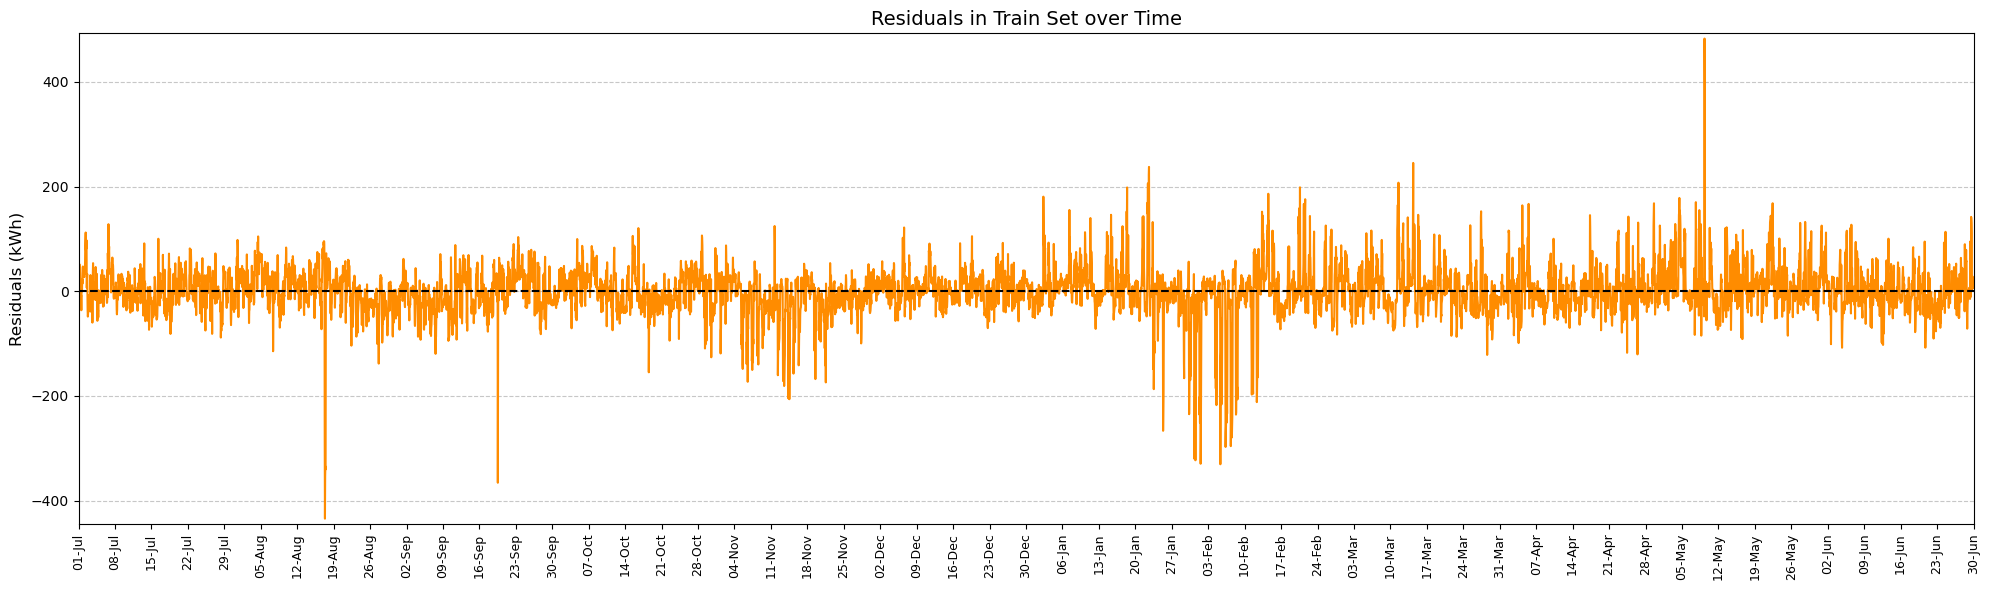

In [109]:
# Plot the Train residuals
train_start = pd.Timestamp("2018-07-01")
train_end = pd.Timestamp("2019-06-30")

plt.figure(figsize=(20, 6))

plt.plot(train_data["Date"], train_data["Residuals"], label="Train Residuals", linestyle="-", color="darkorange")
plt.axhline(y=0, color="black", linestyle="--")

plt.ylim(residual_min-10, residual_max+10)
plt.xlim(pd.Timestamp(train_start), pd.Timestamp(train_end))

plt.xlabel("")
plt.ylabel("Residuals (kWh)", fontsize=12)
plt.title("Residuals in Train Set over Time", fontsize=14)

month_ticks = pd.date_range(start=train_start, end=train_end , freq="W")
plt.xticks(month_ticks, month_ticks.strftime("%d-%b"), rotation=90, fontsize=9)

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

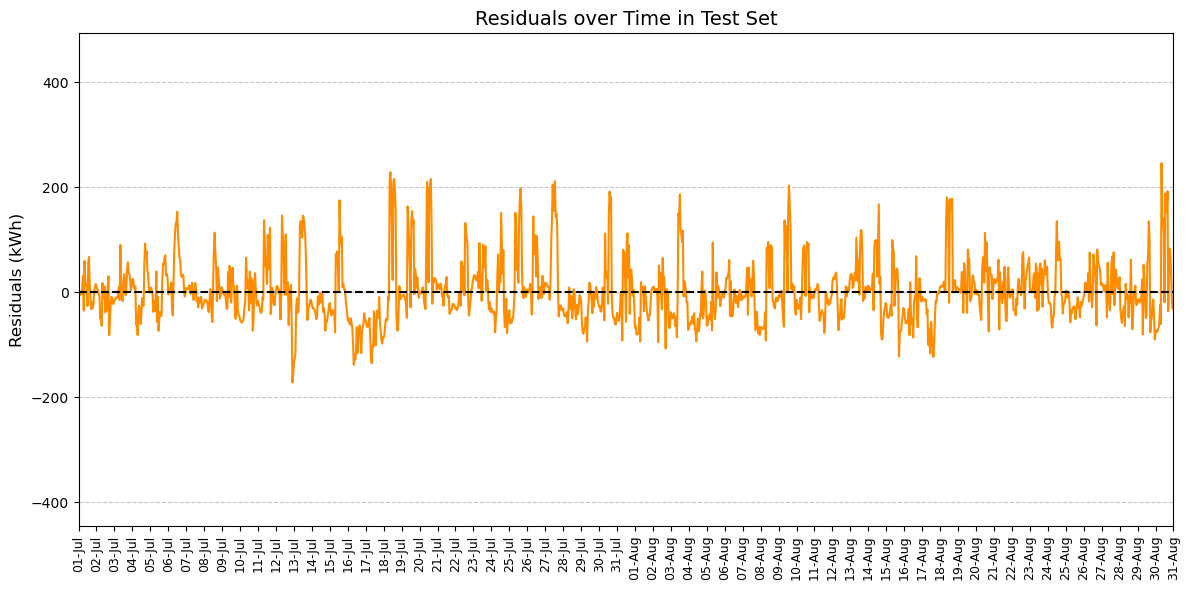

In [108]:
# Plot the Test residuals
test_start = pd.Timestamp("2019-07-01")
test_end = pd.Timestamp("2019-08-31")

# Plot the Test residuals
plt.figure(figsize=(12, 6))
plt.plot(test_data["Date"], test_data["Residuals"], label="Test Residuals", linestyle="-", color="darkorange")
plt.axhline(y=0, color="black", linestyle="--")

plt.ylim(residual_min-10, residual_max+10)
plt.xlim(pd.Timestamp(test_start), pd.Timestamp(test_end))

plt.xlabel("")
plt.ylabel("Residuals (kWh)", fontsize=12)
plt.title("Residuals over Time in Test Set", fontsize=14)

month_ticks = pd.date_range(start=test_start, end=test_end, freq="D")
plt.xticks(month_ticks, month_ticks.strftime('%d-%b'), rotation=90, fontsize=9)

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

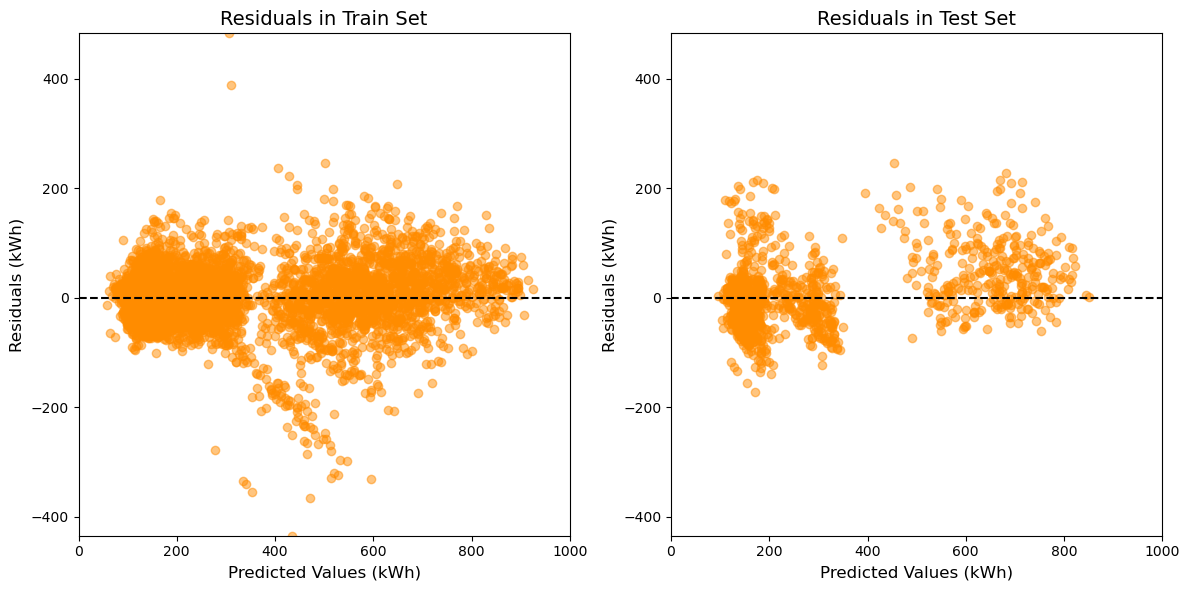

In [104]:
# Plot residuals
plt.figure(figsize=(12, 6))

# Train residuals
plt.subplot(1, 2, 1)
plt.scatter(y_pred_train_final, final_residuals_train, color='darkorange', alpha=0.5)
plt.axhline(y=0, color='black', linestyle='--')
plt.ylim(residual_min, residual_max)
plt.xlim(0, 1000)
plt.title('Residuals in Train Set', fontsize=14)
plt.xlabel('Predicted Values (kWh)', fontsize=12)
plt.ylabel('Residuals (kWh)', fontsize=12)

# Test residuals
plt.subplot(1, 2, 2)
plt.scatter(y_pred_test, final_residuals_test, color='darkorange', alpha=0.5)
plt.axhline(y=0, color='black', linestyle='--')
plt.ylim(residual_min, residual_max)
plt.xlim(0, 1000)
plt.title('Residuals in Test Set', fontsize=14)
plt.xlabel('Predicted Values (kWh)', fontsize=12)
plt.ylabel('Residuals (kWh)', fontsize=12)

plt.tight_layout()
plt.show()

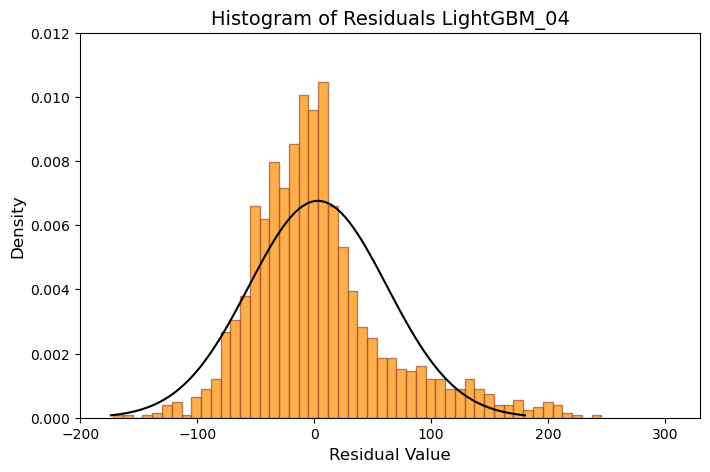

In [86]:
# Histogram of Residuals
plt.figure(figsize=(8, 5))
plt.hist(final_residuals_test, bins=50, density=True, alpha=0.7, color="darkorange", edgecolor="sienna")

# Calculate mean and standard deviation
mu, sigma = np.mean(final_residuals_test), np.std(final_residuals_test)

# Plot normal distribution curve
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), color="black", linewidth=1.5)

# Add labels and title
plt.xlabel("Residual Value", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Histogram of Residuals LightGBM_04", fontsize=14)

plt.xlim(-200, 330)  # Set x-axis limit
plt.ylim(0, 0.012)   # Set y-axis limit

# Display plot
plt.show()


In [87]:
# Residual statistics
residual_stats = {
    "Mean": np.mean(final_residuals_test),
    "Variance": np.var(final_residuals_test),
    "Skewness": stats.skew(final_residuals_test),     # skewness / asymmetry of the distribution
    "Kurtosis": stats.kurtosis(final_residuals_test)  # tailedness of the distribution
}
# Display residual statistics in a DataFrame
residual_df_summary = pd.DataFrame(residual_stats, index=["Residuals"])
print(residual_df_summary.round(3))

           Mean  Variance  Skewness  Kurtosis
Residuals  3.25  3482.128     1.037     1.651


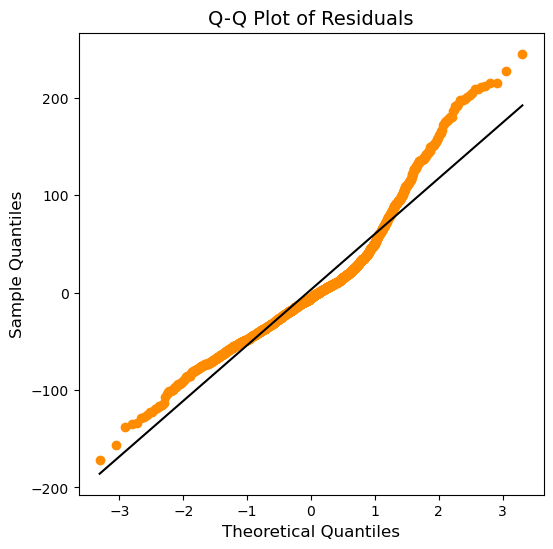

In [88]:
# Q-Q Plot for Normality Check
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)  # Add subplot to get axis object

# Generate Q-Q plot
stats.probplot(final_residuals_test, dist="norm", plot=ax)

# Customize colors
ax.get_lines()[0].set_color('darkorange')  # Data points
ax.get_lines()[1].set_color('black')       # 45-degree line

# Add titles and labels
ax.set_title("Q-Q Plot of Residuals", fontsize=14)
ax.set_xlabel("Theoretical Quantiles", fontsize=12)
ax.set_ylabel("Sample Quantiles", fontsize=12)

# Display plot
plt.show()

In [89]:
# -------------------------------
# kWh Plots
# -------------------------------

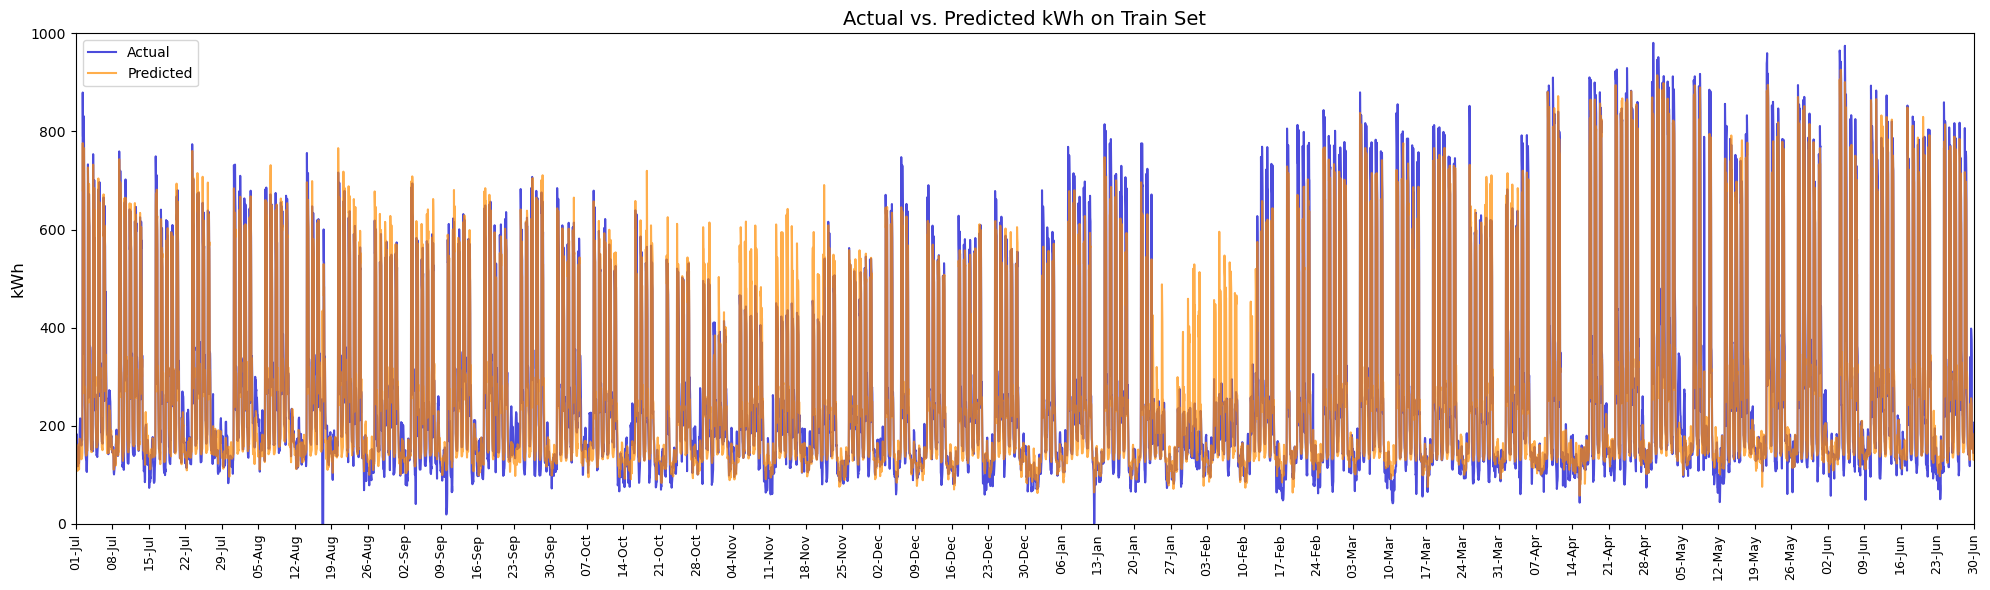

In [115]:
# (a) Actual vs. Predicted over time on Train set
train_start = pd.Timestamp("2018-07-01")
train_end = pd.Timestamp("2019-06-30")

plt.figure(figsize=(20,6))
plt.plot(train_data['Date'], y_train, label='Actual', linestyle='-', color='mediumblue', alpha=0.7)
plt.plot(train_data['Date'], y_pred_train_final, label='Predicted', linestyle='-', color='darkorange', alpha=0.7)
plt.xlabel('')
plt.ylabel('kWh', fontsize=12)
plt.ylim(0, 1000)
plt.title('Actual vs. Predicted kWh on Train Set', fontsize=14)
plt.legend()

month_ticks = pd.date_range(start=train_start, end=train_end , freq="W")
plt.xticks(month_ticks, month_ticks.strftime("%d-%b"), rotation=90, fontsize=9)

plt.xlim(pd.Timestamp(train_start), pd.Timestamp(train_end))

plt.tight_layout()
plt.show()

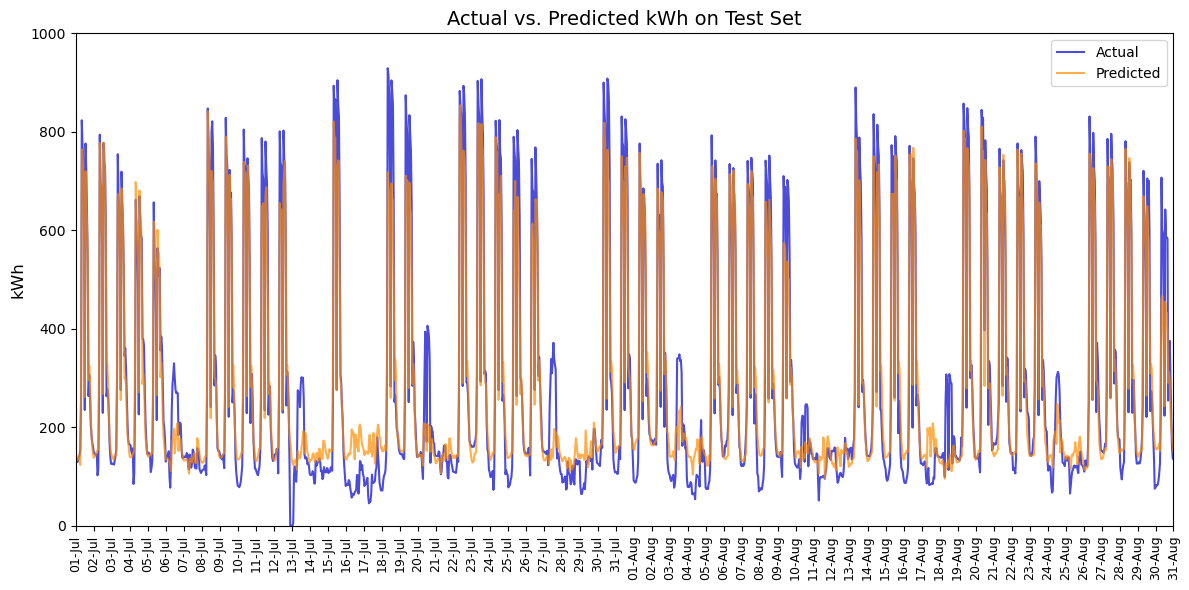

In [95]:
# (a) Actual vs. Predicted over time on Test set
test_start = pd.Timestamp("2019-07-01")
test_end = pd.Timestamp("2019-08-31")

plt.figure(figsize=(12,6))
plt.plot(test_data['Date'], y_test, label='Actual', linestyle='-', color='mediumblue', alpha=0.7)
plt.plot(test_data['Date'], y_pred_test_final, label='Predicted', linestyle='-', color='darkorange', alpha=0.7)
plt.xlabel('')
plt.ylabel('kWh', fontsize=12)
plt.ylim(0, 1000)
plt.title('Actual vs. Predicted kWh on Test Set', fontsize=14)
plt.legend()

month_ticks = pd.date_range(start=test_start, end=test_end, freq='D')
plt.xticks(month_ticks, month_ticks.strftime('%d-%b'), rotation=90, fontsize=9)

plt.xlim(pd.Timestamp(test_start), pd.Timestamp(test_end))

plt.tight_layout()
plt.show()

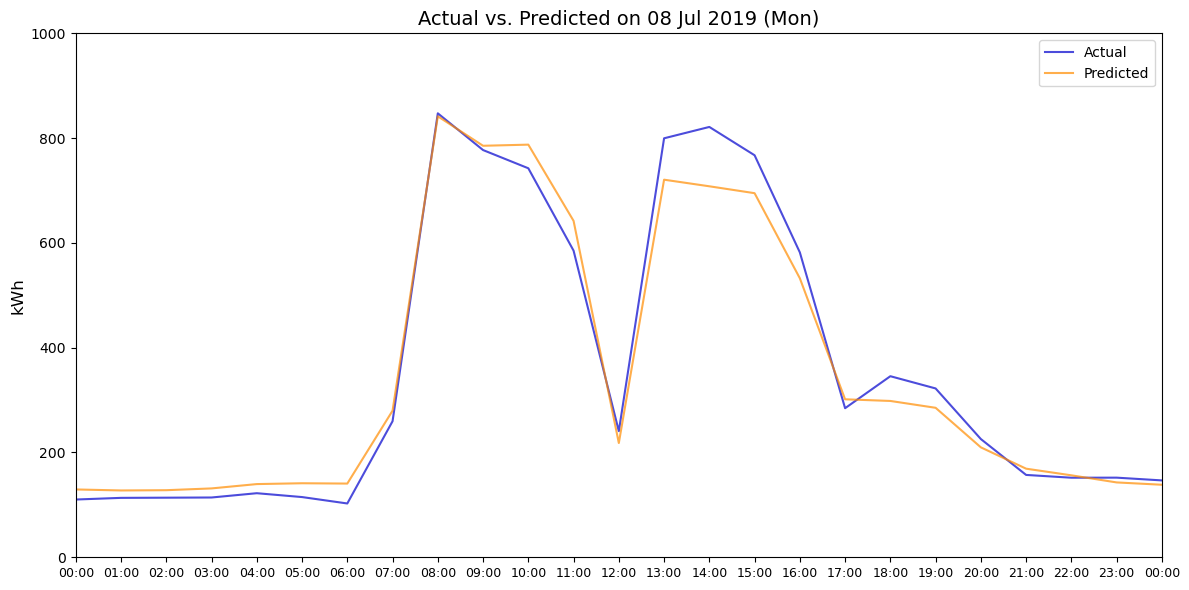

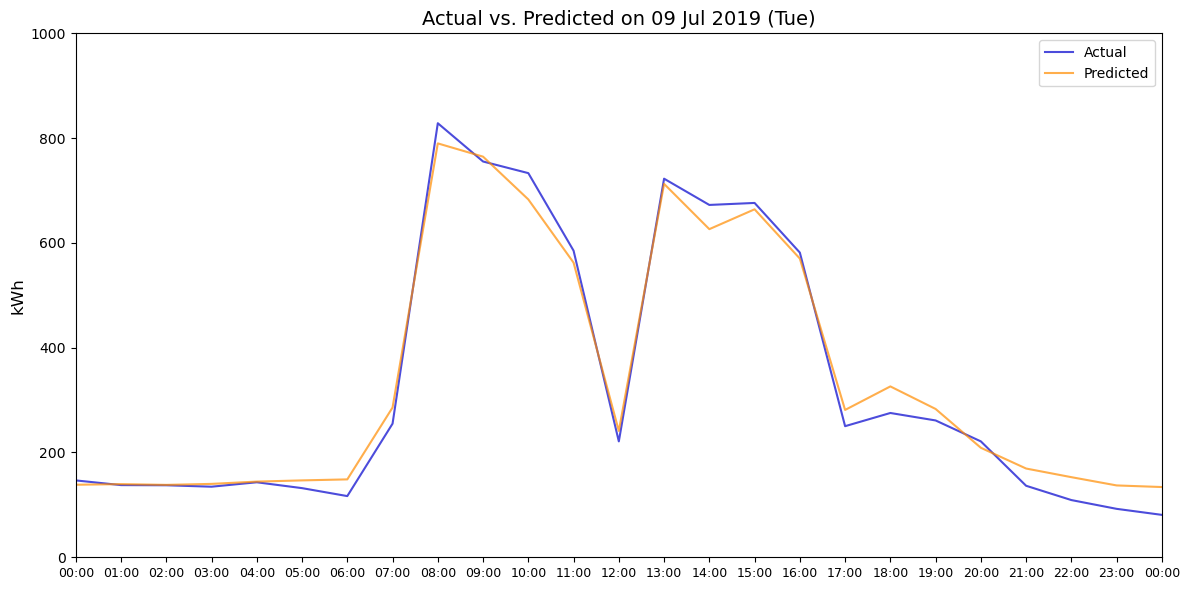

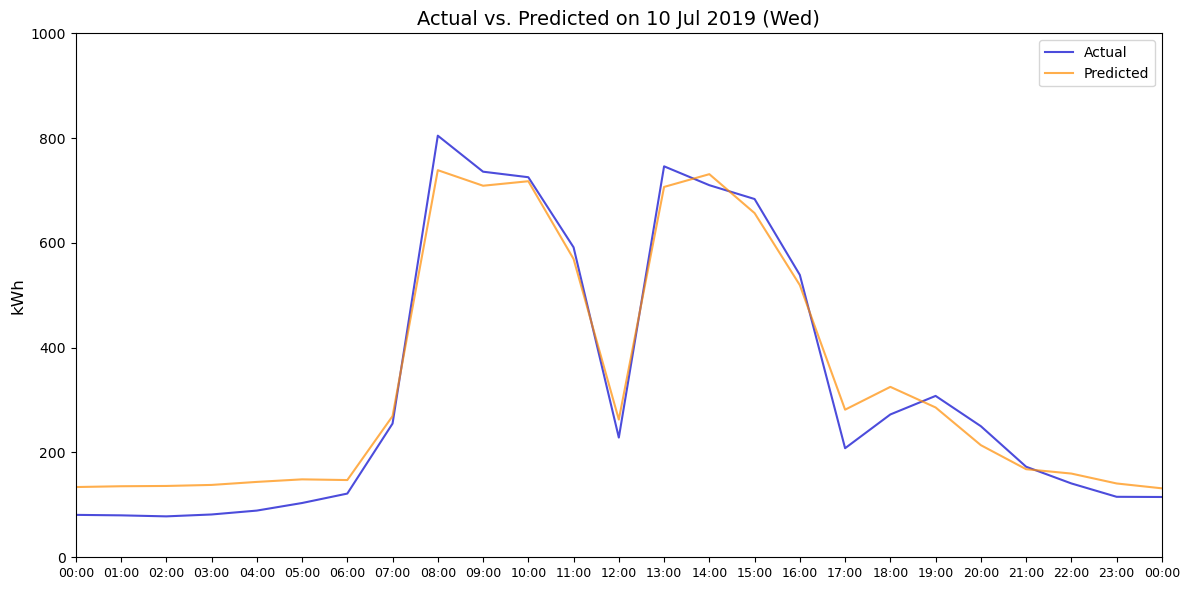

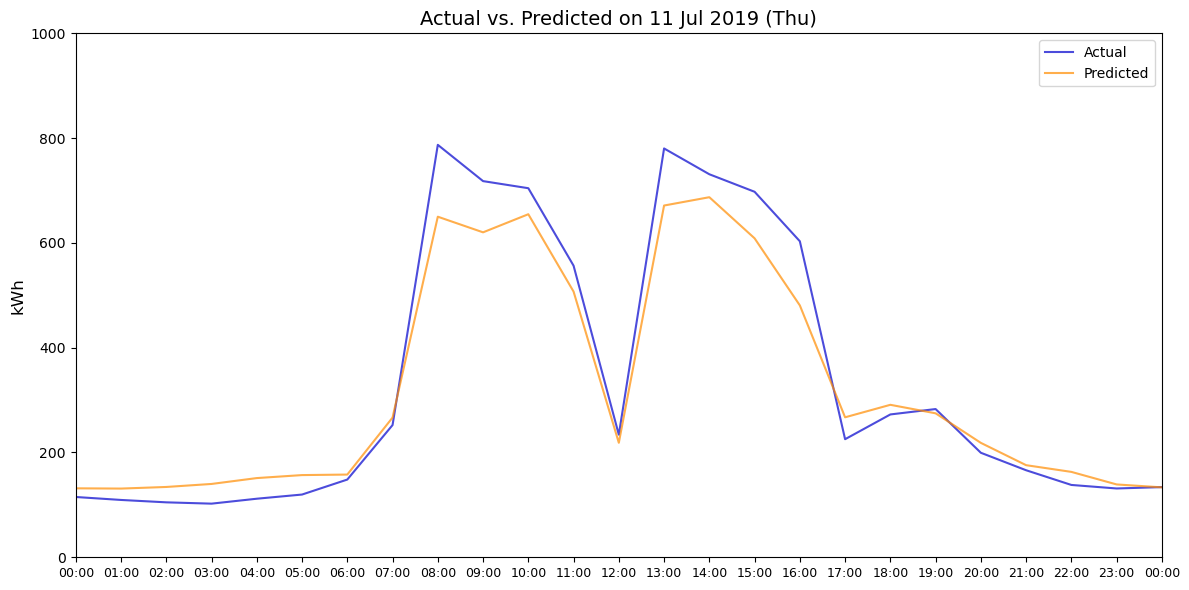

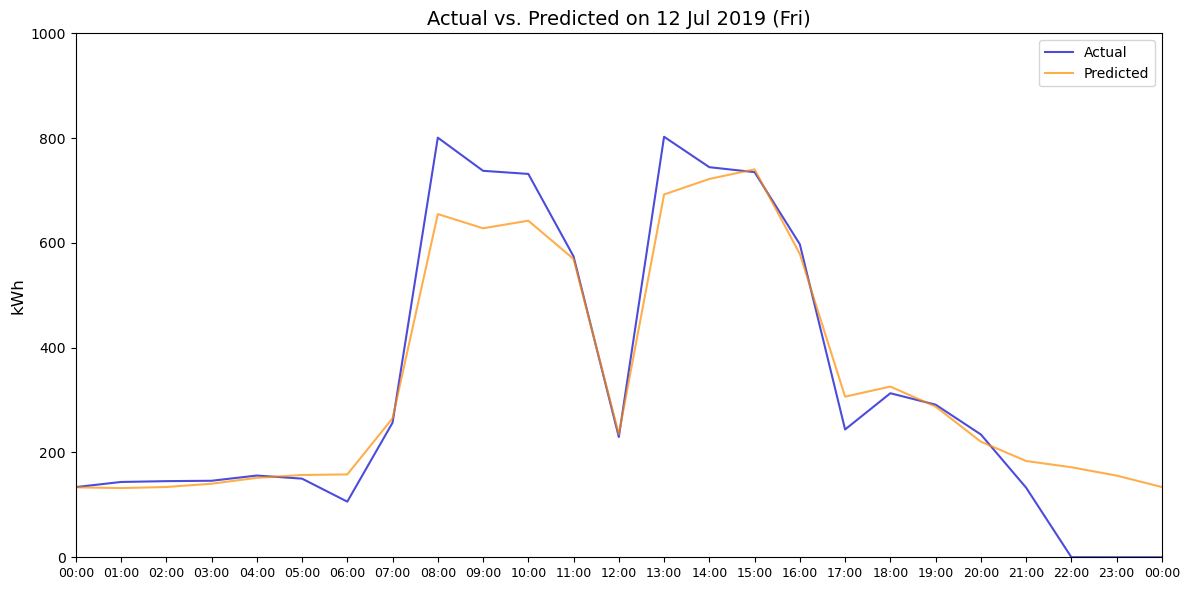

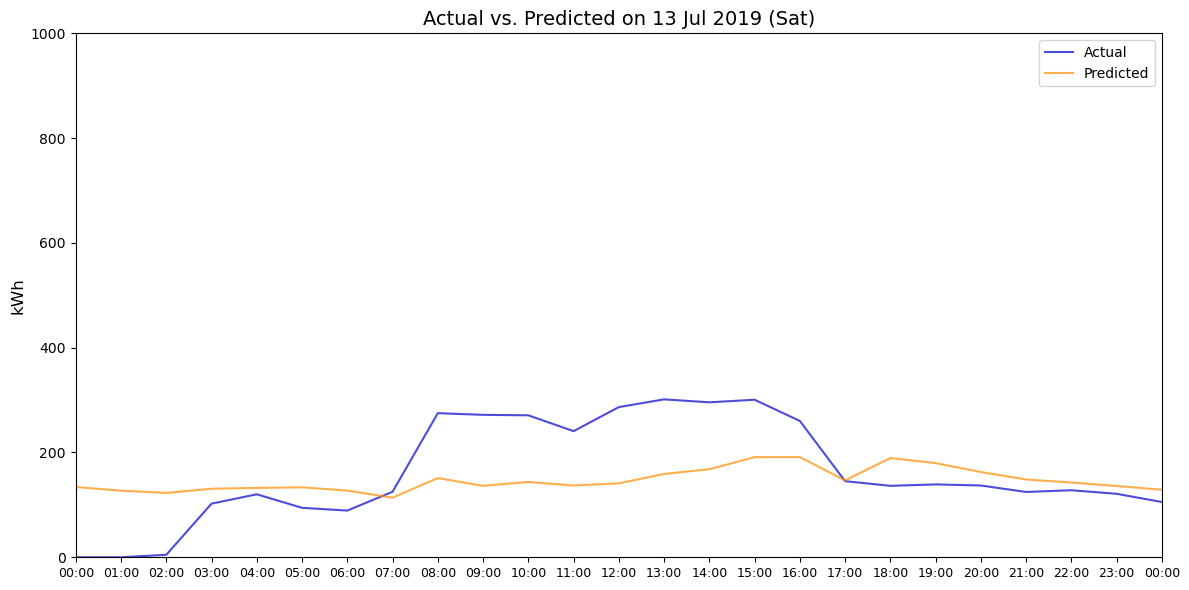

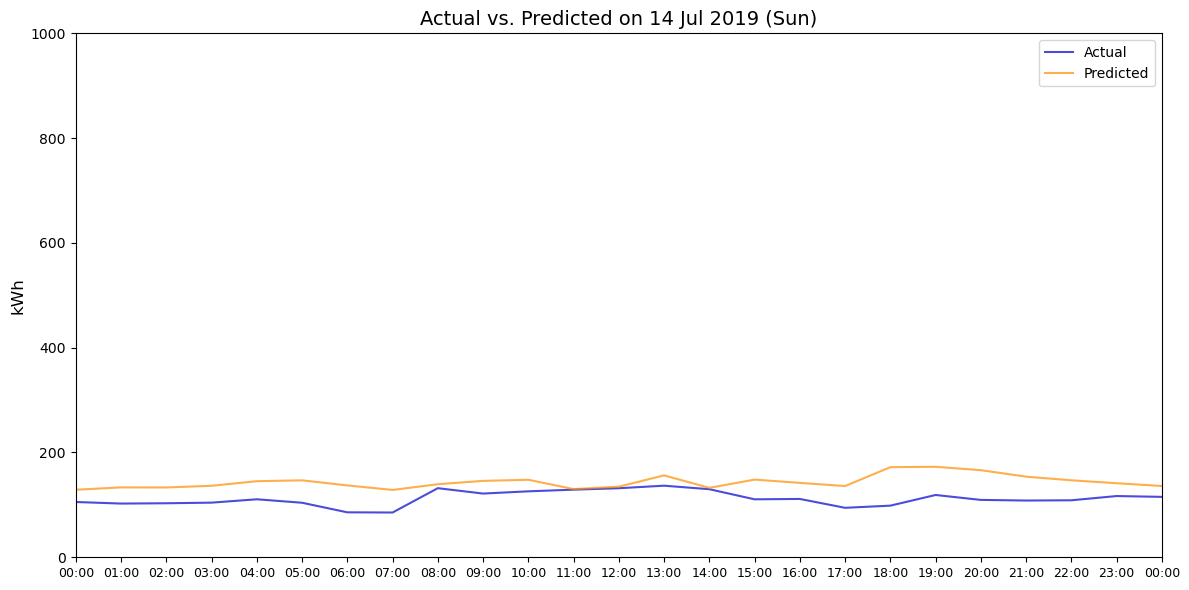

In [91]:
# Define the specific dates you want to plot
selected_days = ['2019-07-08', '2019-07-09', '2019-07-10', '2019-07-11', '2019-07-12', '2019-07-13', '2019-07-14']

# Convert to datetime for accurate filtering
selected_days = pd.to_datetime(selected_days)

# Loop through each selected day and plot
for day in selected_days:
    # Filter data for the current day and include 00:00 of the next day
    mask = (test_data['Date'] >= day) & (test_data['Date'] <= day + pd.Timedelta(days=1))
    filtered_data = test_data[mask]
    filtered_y_test = y_test[mask]
    filtered_y_pred = y_pred_test_final[mask]

    # Plotting Actual vs. Predicted for the current day
    plt.figure(figsize=(12, 6))
    plt.plot(filtered_data['Date'], filtered_y_test, label='Actual', linestyle='-', color='mediumblue', alpha=0.7)
    plt.plot(filtered_data['Date'], filtered_y_pred, label='Predicted', linestyle='-', color='darkorange', alpha=0.7)

    plt.xlabel('')
    plt.ylabel('kWh', fontsize=12)
    plt.ylim(0, 1000)
    #plt.title(f'Actual vs. Predicted on {day.strftime("%d-%b-%Y")}', fontsize=14)
    plt.title(f'Actual vs. Predicted on {day.strftime("%d %b %Y (%a)")}', fontsize=14)

    plt.legend()

    # Set x-axis ticks to every hour, extending to 00:00 of the next day
    hour_ticks = pd.date_range(start=day, end=day + pd.Timedelta(days=1), freq='h')
    plt.xticks(hour_ticks, hour_ticks.strftime('%H:%M'), fontsize=9)

    # Adjust x-axis limits to extend until 00:00 of the next day
    plt.xlim(day, day + pd.Timedelta(days=1))

    plt.tight_layout()
    plt.show()

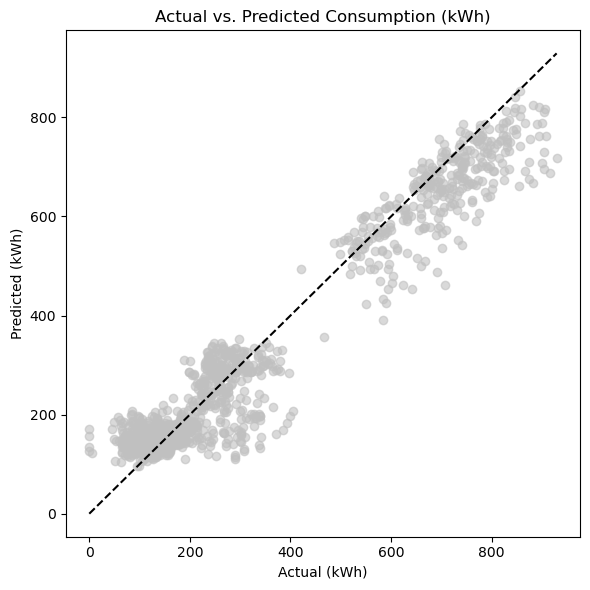

In [92]:
# Scatter plot of Actual vs. Predicted values
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test_final, color='silver', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='black', linestyle='--')  # 45-degree line
plt.xlabel('Actual (kWh)')
plt.ylabel('Predicted (kWh)')
plt.title('Actual vs. Predicted Consumption (kWh)')
plt.tight_layout()
plt.show()

In [ ]:
####################### The End #######################